#### Database

In [2]:
PROJECT_PATH = '/home/md/Work/ligalytics/leagues_stable/'
import os, sys
sys.path.insert(0, PROJECT_PATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "leagues.settings")

from leagues import settings
settings.DATABASES['default']['NAME'] = PROJECT_PATH+'/db.sqlite3'

import django
django.setup()

from scheduler.models import *
from common.functions import distanceInKmByGPS
season = Season.objects.filter(nicename="Imported: Benchmark Season").first()
import pandas as pd
import numpy as np
from django.db.models import Count, F, Value
games = Game.objects.filter(season=season)
df = pd.DataFrame.from_records(games.values())
games = Game.objects.filter(season=season).annotate(
    home=F('homeTeam__shortname'),
    away=F('awayTeam__shortname'),
    home_lat=F('homeTeam__latitude'),
    home_lon=F('homeTeam__longitude'),
    home_attr=F('homeTeam__attractivity'),
    away_lat=F('awayTeam__latitude'),
    away_lon=F('awayTeam__longitude'),
    away_attr=F('awayTeam__attractivity'),
    home_country=F('homeTeam__country'),
    away_country=F('awayTeam__country'),
).values()



#### Dataframe

In [19]:
from sklearn.preprocessing import OneHotEncoder

# create dataset
df = pd.DataFrame.from_records(games.values())

# pivots
pivot_homeTeam_mean = df.pivot_table('attendance','homeTeam_id',aggfunc='mean')
pivot_homeTeam_max = df.pivot_table('attendance','homeTeam_id',aggfunc='max')

# add more features
df['weekday'] = df.apply(lambda r: r['date'].weekday(), axis=1)
df['day'] = df.apply(lambda r: r['date'].day, axis=1)
df['month'] = df.apply(lambda r: r['date'].month, axis=1)
df['year'] = df.apply(lambda r: r['date'].year, axis=1)
df['distance'] = df.apply(lambda r: distanceInKmByGPS(r['home_lon'],r['home_lat'],r['away_lon'],r['away_lat']), axis=1)
df['weekend'] = df.apply(lambda r: int(r['weekday'] in [6,7]), axis=1)
df['winter_season'] = df.apply(lambda r: int(r['month'] in [1,2,3,10,11,12]), axis=1)
df['home_base'] = df.apply(lambda r: pivot_homeTeam_mean.loc[r['homeTeam_id'],'attendance'], axis=1)
df['stadium_size'] = df.apply(lambda r: pivot_homeTeam_max.loc[r['homeTeam_id'],'attendance'], axis=1)
df['early'] = df.apply(lambda r: int(r['time'].replace(':','') < "1800"), axis=1)
df['before2010'] = df.apply(lambda r: int(r['historic_season'].split('-')[0] < "2010"), axis=1)


# one hot encoding
ohe_fields = ['home_country']

for field in ohe_fields:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[field]])
    df[ohe.categories_[0]] = transformed.toarray()

# sort label to last index
cols = list(df.columns)
cols.append(cols.pop(cols.index('attendance')))
df = df[cols]

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


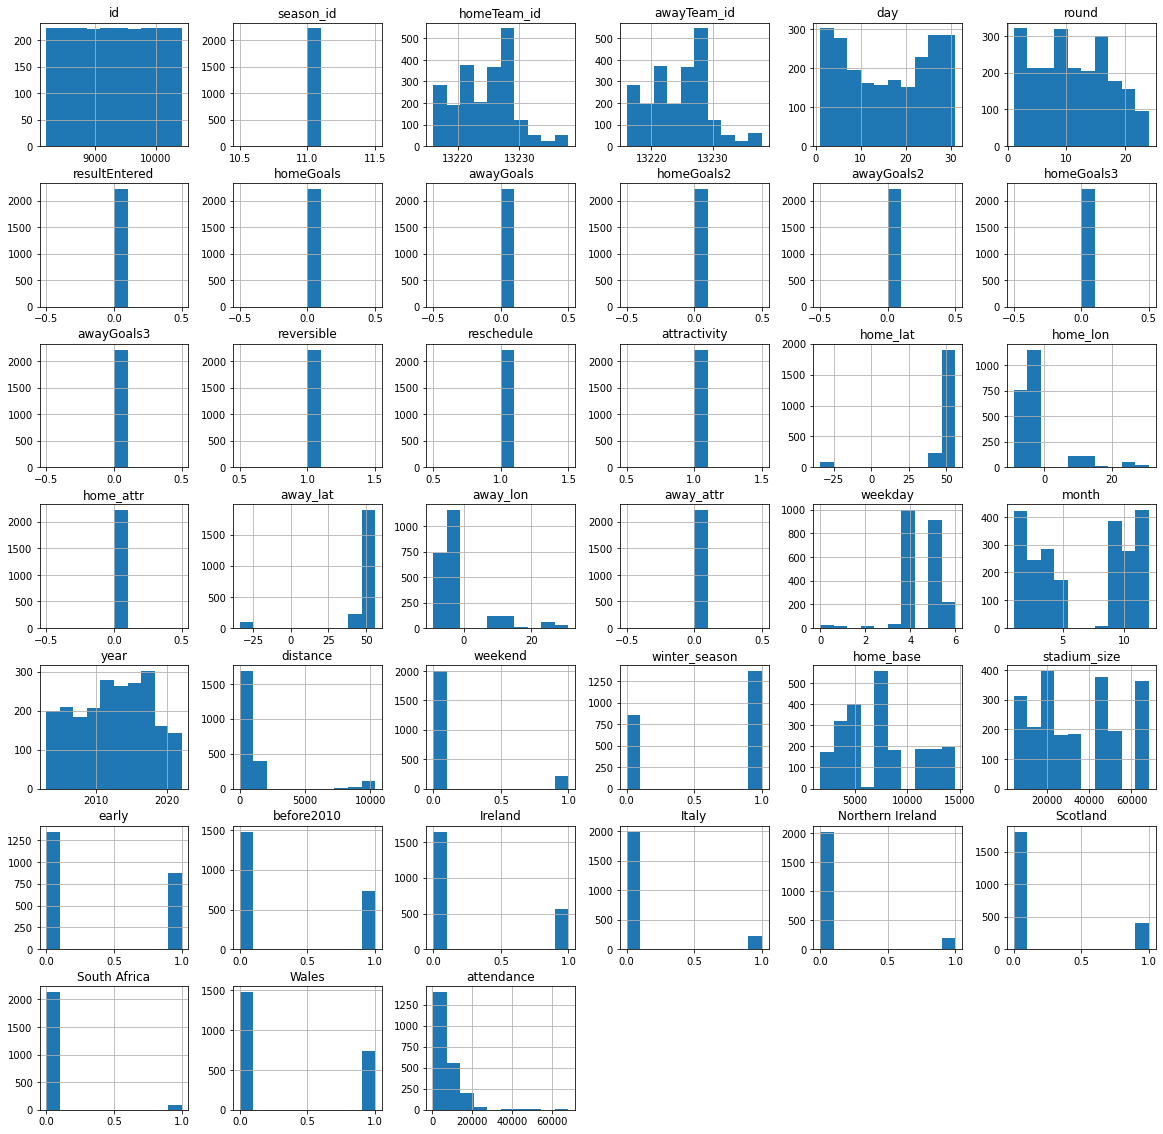

In [21]:
df.hist(figsize = (20,20))
plt.show()

#### Train/Test Data - Normalization

In [24]:
from sklearn.model_selection import train_test_split



remove_columns = ['season_id', 'resultEntered', 'reversible', 'reschedule', 'homeGoals', 'awayGoals',
                  'homeGoals2', 'awayGoals2', 'homeGoals3', 'awayGoals3', 'home', 'away', 'date', 'time',
                  'id', 'homeTeam_id', 'awayTeam_id', 'historic_season',
                  'home_country','home_lat','home_lon','away_lat','away_lon','away_country']
feature_cols = list(set(df.columns[:-1]) - set(remove_columns))
# feature_cols = ['weekday','weekend','home_base','distance','winter_season']
label = 'attendance'


X = df[feature_cols]  # Features
y = df[label]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

#### Correlation Matrix

<AxesSubplot:>

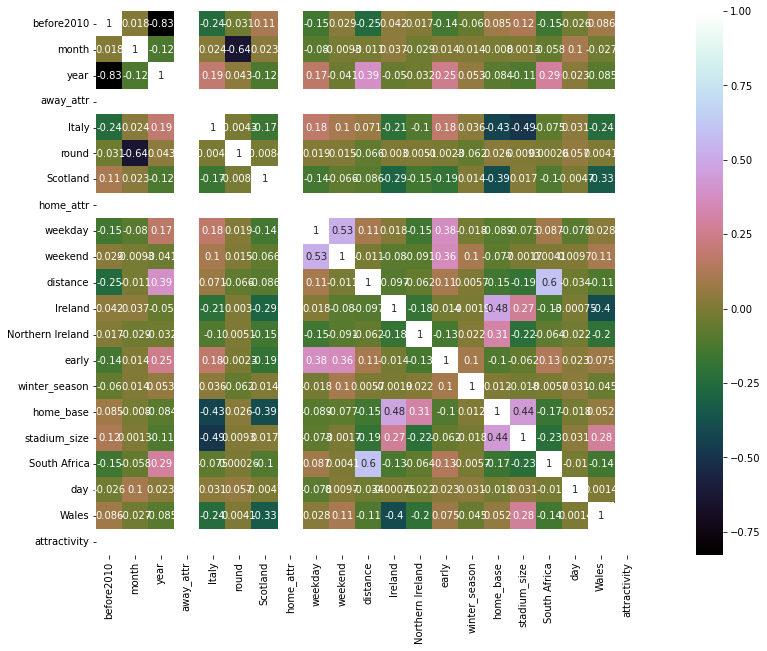

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
# GETTING Correllation matrix
corr_mat=X_train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [26]:
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)

Text(0, 0.5, 'Cumulative explained variance')

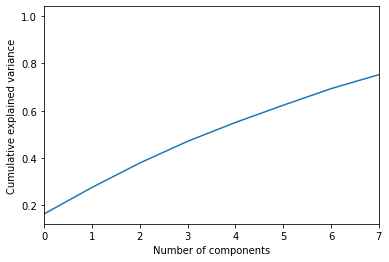

In [27]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/distr

(-2.0, 2.0)

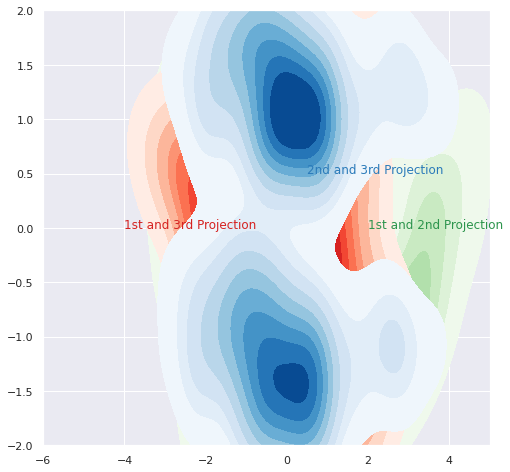

In [28]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=5)
X_Train=sklearn_pca.fit_transform(X_std)

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect('equal')
ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
          shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-6,5)
plt.ylim(-2,2)